# PART 1 : Linear Regression, Ridge, LASSO for Mars and Sun.

From the early project S, we collected data from the Stellarium and it is consists of 9 celestial bodies with 8 features; time, right ascension, declination, azimuthal angle, altitude, Distance, Distance from the sun, constellations. In principle, the motion of celestial body in solar system is determined by 13 variables; velocity of body (w.r.t sun), position of body (w.r.t sun), velocity of earth (w.r.t sun), position of earth (w.r.t sun) and time. With the given mass of earth, body and sun, one can predict the future position of celestial body quiet exactly. <br>
But here, our approach is slightly different from the physics. We will try to predict position of body in celestial sphere based on the past data using different regression techniques. As a start, we will try the basic regression techniques - Linear Regression, Ridge Regression, LASSO. <br>
There are a few principles we are going to keep during regression; since we are trying to mimic past astronomers who's object is predict future data based on past data, we will going to collect 40 ~ 50 year's location of celestial body in the celestial sphere and going to predict next 5 ~ 10 years location of them. Our data is collected from certain location in China (Luoyang), from A.C. 118 to 168. This would be a harsh condition for training since our training point and testing point are totally separated and time series problem. Thus, we are going to use huge number of additional features, which are Fourier featured version of time. (Considering that celestial motions are periodic function, Fourier features might be helpful.) Of course this is approach that past astronomers cannot use, so we will try with small number of features too in part 2.

## 1-1 : Fourier-Featurized time Version - Predicting Mars position

As we explained, we will use Fourier featurized time as out input matrix, and train them with given y's, the data of each feature we want to predict (right ascension, declination, azimuthal angle, altitude, Distance, Distance from the sun). Main object here is too check whether can we predict above features only based on time or not.

In [2]:
import numpy as np # cientific computing
import datetime # basic date and time types
import jdcal # functions for converting between Julian dates and calendar dates
import pandas as pd # data analysis
import pickle # object serialization
import getpass # group work
from jdcal import MJD_0
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

In [3]:
df = pd.read_pickle("/Users/yun/Desktop/codes/CS-289A-Proj-SF-XYKF/data_133183_0.1.df")

In [4]:
def regression_models_ff(target = 'Az', body = 'Mars', model = 'Linear', hyper = 0.1, num_feature = 200,
                         option = False, add_polynomiaml = False):
    
    dfMars = df.loc[df['Body'] == body]
    X = pd.DataFrame(dfMars['JD'])
    JD = np.array(X['JD'])
    t = np.subtract(JD, JD[0])
    
    Dec = pd.DataFrame(dfMars['Dec'])
    n_Dec = Dec.divide(Dec.max())
    
    if not add_polynomiaml:
        for omega in np.linspace(0, 2*np.pi, num=num_feature):
            X['sin'+str(omega)] = np.array(np.sin(omega*t))
            X['cos'+str(omega)] = np.array(np.cos(omega*t))
    else:
        for omega in np.linspace(0, 2*np.pi, num=num_feature):
            X['sin'+str(omega)] = np.array(np.sin(omega*t))
            X['cos'+str(omega)] = np.array(np.cos(omega*t))
        for fea in add_polynomiaml:
            vec = pd.DataFrame(dfMars[fea])
            n_vec = vec.divide(vec.max())
            for n in np.arange(0,100,1):
                X[fea+str(n)+'_order'] = n_vec ** n
            
    y = dfMars[target]
    X_train_JD, X_test_JD, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)
    X_train = X_train_JD.drop(['JD'], axis=1)
    X_test = X_test_JD.drop(['JD'], axis=1)

    if model == 'Linear':
        reg = LinearRegression()
        reg.fit(X_train, y_train)
        y_train_pred = reg.predict(X_train)
        y_test_pred = reg.predict(X_test)
    elif model == 'Ridge':
        reg = GridSearchCV(Ridge(), param_grid={"alpha":[100, 10, 1, 0.1, 0.01]})
        reg.fit(X_train, y_train)
        y_train_pred = reg.predict(X_train)
        y_test_pred = reg.predict(X_test)
        print(reg.get_params())
    elif model == 'LASSO':
        reg = GridSearchCV(Lasso(), param_grid={"alpha":[100, 10, 1, 0.1, 0.01, 0.001], "tol":[1, 0.1, 0.01, 0.001]})
        reg.fit(X_train, y_train)
        y_train_pred = reg.predict(X_train)
        y_test_pred = reg.predict(X_test)
        print(reg.get_params())
    else:
        print('no other models for now')

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    if option == False:
        return mse_train, mse_test
    else:
        return X_train_JD['JD'].values, X_test_JD['JD'].values, y_train_pred, y_test_pred

def train_test_plot(traindata, testdata, numfeatures, suptitle = ''):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(suptitle)

    for i in traindata:
        ax1.plot(num_features, traindata[i], label=i)
    ax1.set_yscale('log')
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Training MSE')
    ax1.legend()

    for i in testdata:
        ax2.plot(num_features, testdata[i], label=i)
    ax2.set_yscale('log')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Test MSE')
    ax2.legend()

    plt.show()

### 1-1 Results : Linear Regression of Mars position

First part is based on the Linear Regression. As one can see from the first result, training MSE keep lowering as number of features incresing. However, test MSE is not much improved by adding features. Second plot shows how the training and prediction works with 3000 features. Training is perfectly match with input data, but prediction is far away from the original data. <br>
As expected, it is really hard to predict postion using Linear regression only. Periodicity is well predicted, but absoulte scale of prediction is different, since a lot of features which lowering training MSE reversely hampering prediction MSE. Thus, we need to compress or contraint coefficient vector using Ridge or LASSO.

In [77]:
# mse of Linear regression with different number of features
linear_mse_train = {}
linear_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    linear_mse_train[i] = []
    linear_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i, model='Linear', num_feature = num_feature)
        linear_mse_train[i].append(mse_train)
        linear_mse_test[i].append(mse_test)

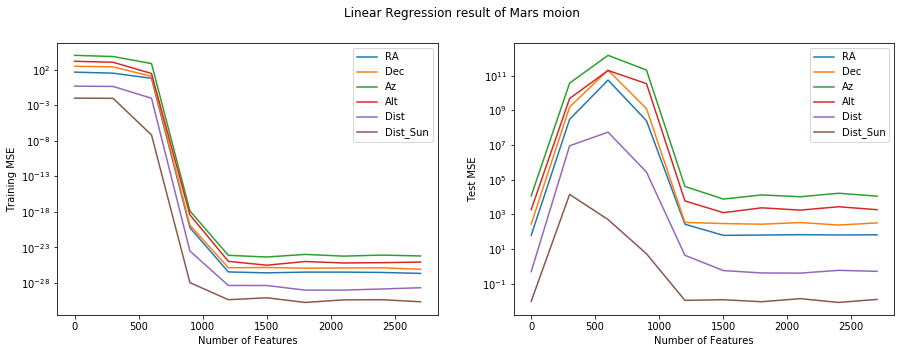

In [78]:
train_test_plot(traindata=linear_mse_train, testdata=linear_mse_test, numfeatures=num_features, 
                suptitle = 'Linear Regression result of Mars moion')

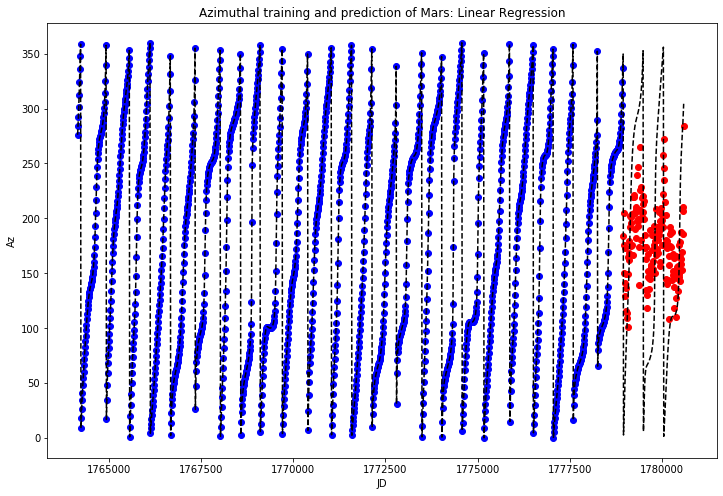

In [129]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Az', model='Linear', num_feature = 1500, option=True)
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfMars['JD'].values, dfMars['Az'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Az')
plt.title('Azimuthal training and prediction of Mars: Linear Regression')
plt.show()

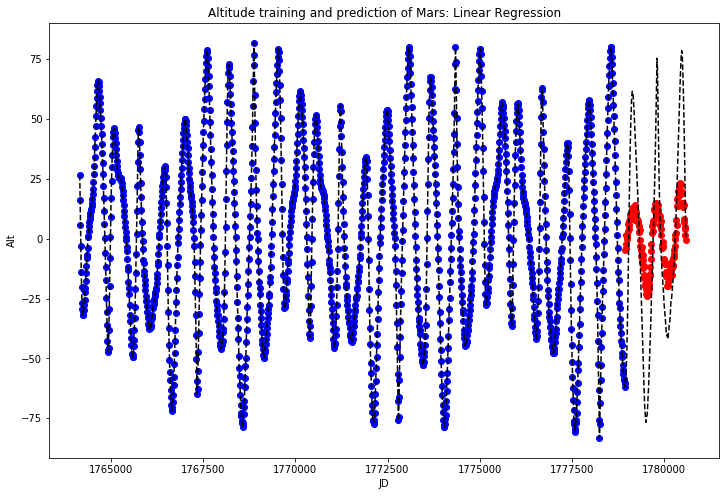

In [135]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', model='Linear', num_feature = 1500, option=True)
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfMars['JD'].values, dfMars['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Mars: Linear Regression')
plt.show()

### 1-1 Results : Ridge Regression of Mars position

Next, we ran Ridge regression instead of linear regression. Since ridge rigression has effect of compressing size of coefficients, we expect slightly better results than linear regression. As one can see from the results, training and test MSE of ridge is not much improved by adding features. It's value is similar with starting point. This is somewhat natural behavior since we only use Fourier-like features and constraints total size of coefficients, there are only limiting choices of features to minimize MSE. The prediction results become smoother than linear regression version but still bad to use.

In [ ]:
# mse of Ridge with different number of features
Ridge_mse_train = {}
Ridge_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    Ridge_mse_train[i] = []
    Ridge_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i, hyper = 100, model='Ridge', num_feature = num_feature)
        Ridge_mse_train[i].append(mse_train)
        Ridge_mse_test[i].append(mse_test)

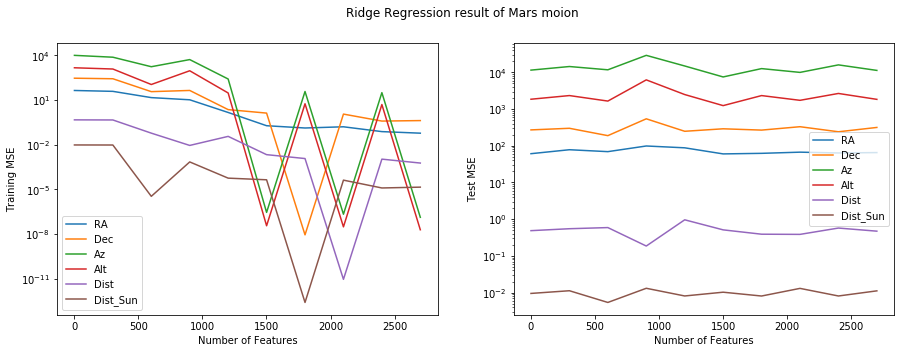

In [82]:
train_test_plot(traindata=Ridge_mse_train, testdata=Ridge_mse_test, numfeatures=num_features, 
                suptitle = 'Ridge Regression result of Mars moion')

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': None, 'estimator__normalize': False, 'estimator__random_state': None, 'estimator__solver': 'auto', 'estimator__tol': 0.001, 'estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


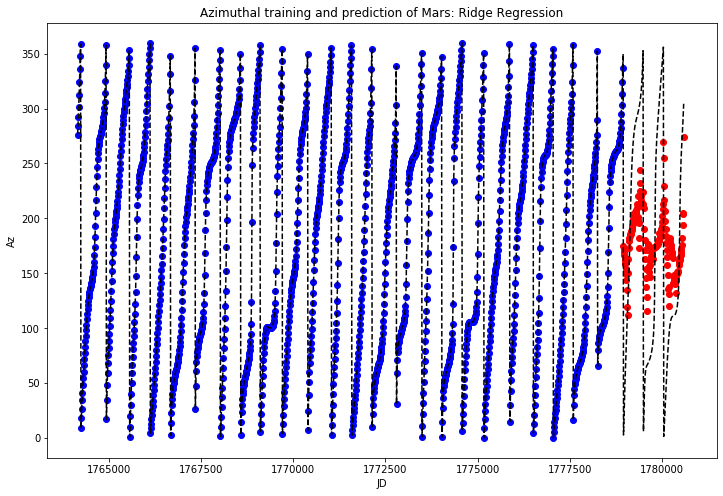

In [136]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Az', model='Ridge', num_feature = 1500, option=True)
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfMars['JD'].values, dfMars['Az'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Az')
plt.title('Azimuthal training and prediction of Mars: Ridge Regression')
plt.show()

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': None, 'estimator__normalize': False, 'estimator__random_state': None, 'estimator__solver': 'auto', 'estimator__tol': 0.001, 'estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


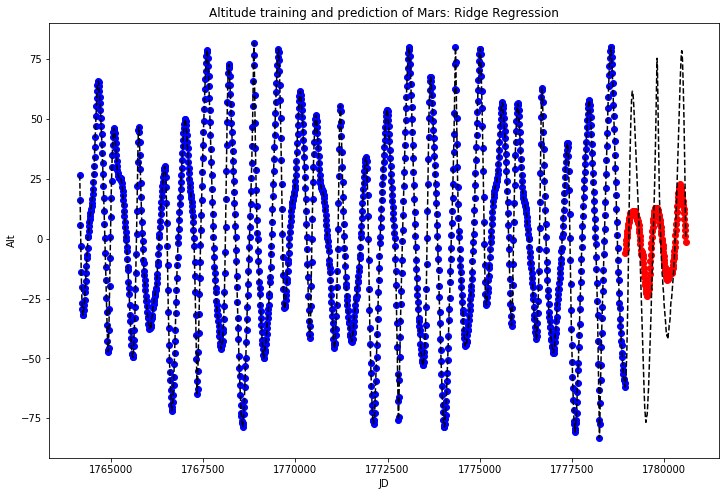

In [137]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', model='Ridge', num_feature = 1500, option=True)
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfMars['JD'].values, dfMars['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Mars: Ridge Regression')
plt.show()

### 1-1 Results : LASSO for Mars position

Finally we test LASSO. This would be better than ridge since we use lots of number of features, and LASSO is good for removing irrelevant (or having small coefficient) features by setting hyperparameter alpha. As one can see from the results, training MSE and test MSE shows quite simialr behavior with ridge, since both have same concept that compressing size of coefficient vector by adding 1-norm or 2-norm term. But the real result is quite different. LASSO's training data is not as much as accurate compare to linear or ridge regression, but test data have better behavior than those two. However, it is still not really good way to predict celestial body's behavior by time.

In [ ]:
# mse of LASSO with different number of features
LASSO_mse_train = {}
LASSO_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    LASSO_mse_train[i] = []
    LASSO_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i, model='LASSO', num_feature = num_feature)
        LASSO_mse_train[i].append(mse_train)
        LASSO_mse_test[i].append(mse_test)

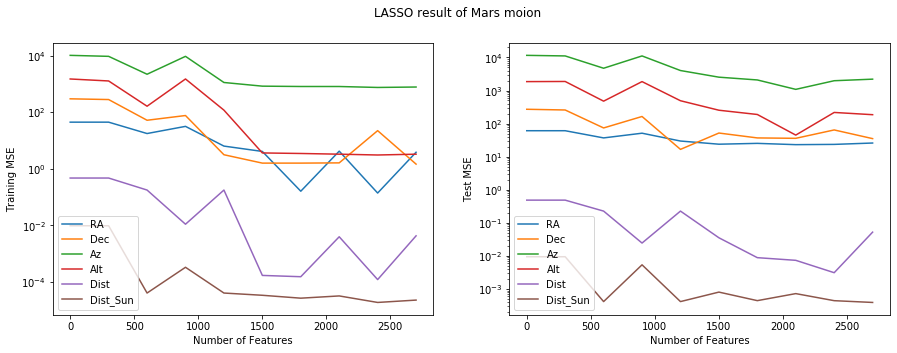

In [98]:
train_test_plot(traindata=LASSO_mse_train, testdata=LASSO_mse_test, numfeatures=num_features, 
                suptitle = 'LASSO result of Mars moion')

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


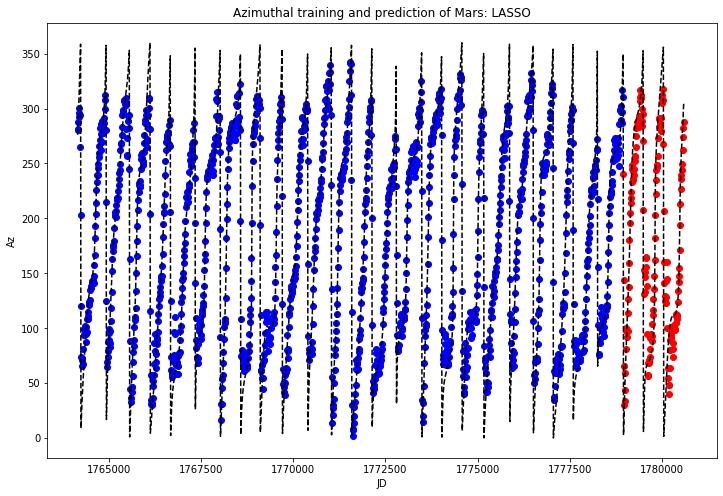

In [141]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Az', model='LASSO', num_feature = 1500, option=True)
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfMars['JD'].values, dfMars['Az'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Az')
plt.title('Azimuthal training and prediction of Mars: LASSO')
plt.show()

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


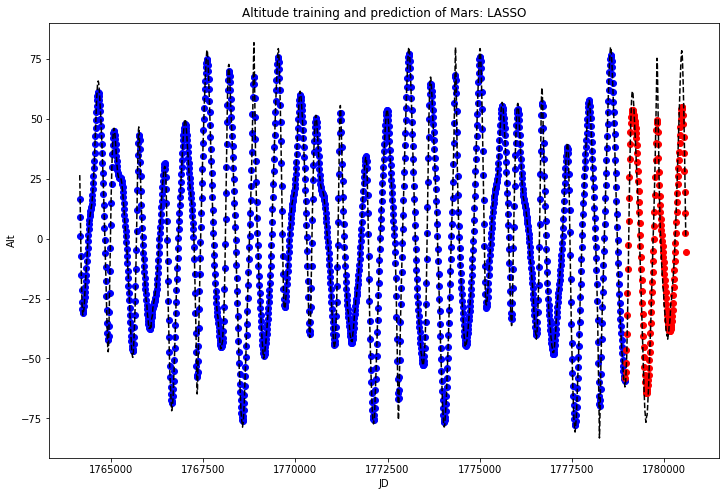

In [142]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', model='LASSO', num_feature = 1500, option=True)
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfMars['JD'].values, dfMars['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Mars: LASSO')
plt.show()

As a conclusion, Fourier featurized time matrix is not appropriate to predict behavior of celestial bodies. The behaviors of bodies are too complicated to express with simple periodic functions, and also since our training, tesing data set are complitly separated by time (not mixed) it increases difficulty of predictions. Also considering that in classical mechanics, we need speed and position of bodies to predict how they will behave by time, it is more natural to incorparate observed data in our featurized matrix (Right Ascension, Declination, etc...). For the next part, we will perform same thing for the sun position.

## 1-2 : Fourier-Featurized time Version - Predicting Sun position

### 1-2 Results : Linear Regression of Sun position

In [146]:
# mse of Ridge with different number of features
Ridge_mse_train = {}
Ridge_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    Ridge_mse_train[i] = []
    Ridge_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i, body='Sun', model='Linear', num_feature = num_feature)
        Ridge_mse_train[i].append(mse_train)
        Ridge_mse_test[i].append(mse_test)

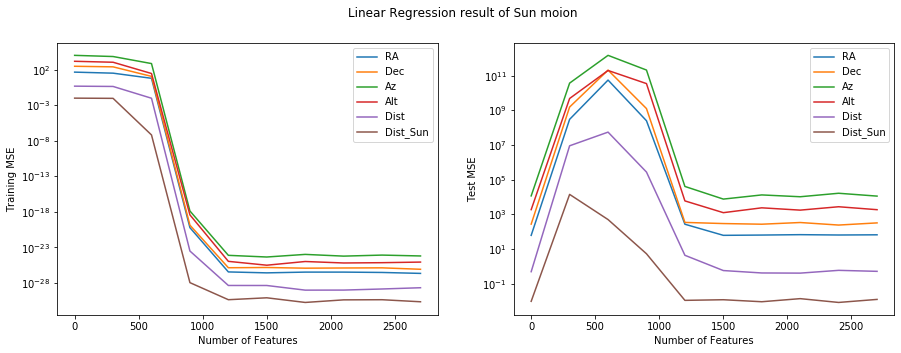

In [104]:
train_test_plot(traindata=linear_mse_train, testdata=linear_mse_test, numfeatures=num_features, 
                suptitle = 'Linear Regression result of Sun moion')

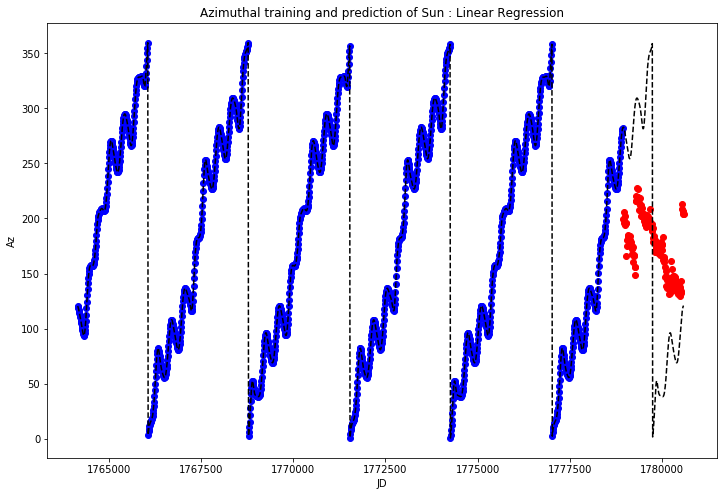

In [144]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Az', body='Sun', model='Linear', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Sun']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Az'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Az')
plt.title('Azimuthal training and prediction of Sun : Linear Regression')
plt.show()

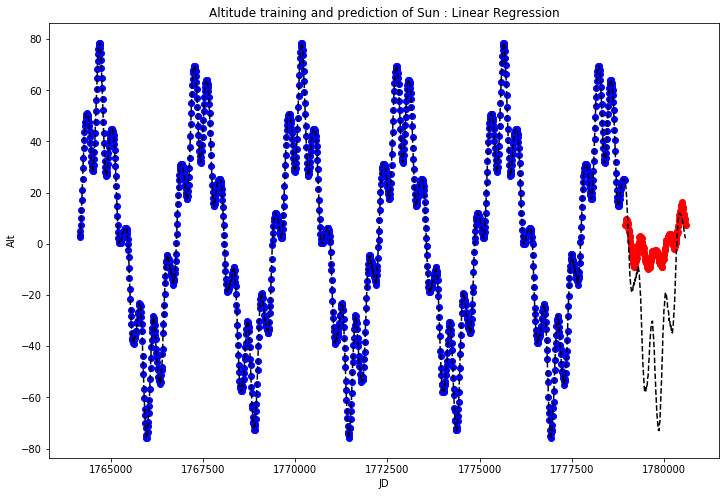

In [145]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', body='Sun', model='Linear', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Sun']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Sun : Linear Regression')
plt.show()

### 1-2 Results : Ridge Regression of Sun position

In [ ]:
Ridge_mse_train = {}
Ridge_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    Ridge_mse_train[i] = []
    Ridge_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i, body='Sun', model='Ridge', num_feature = num_feature)
        Ridge_mse_train[i].append(mse_train)
        Ridge_mse_test[i].append(mse_test)

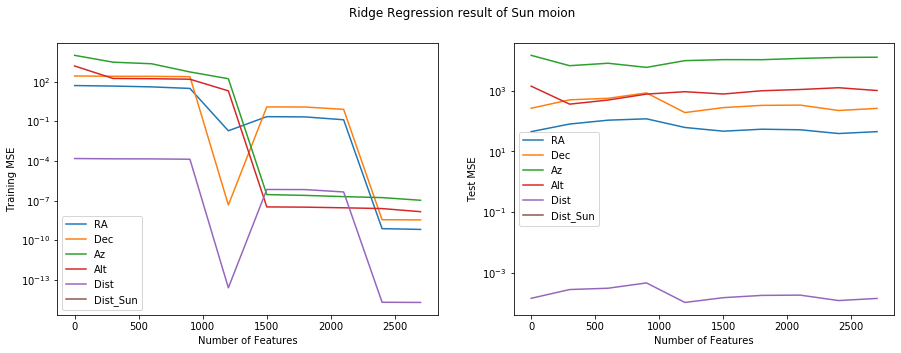

In [114]:
train_test_plot(traindata=Ridge_mse_train, testdata=Ridge_mse_test, numfeatures=num_features, 
                suptitle = 'Ridge Regression result of Sun moion')

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': None, 'estimator__normalize': False, 'estimator__random_state': None, 'estimator__solver': 'auto', 'estimator__tol': 0.001, 'estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


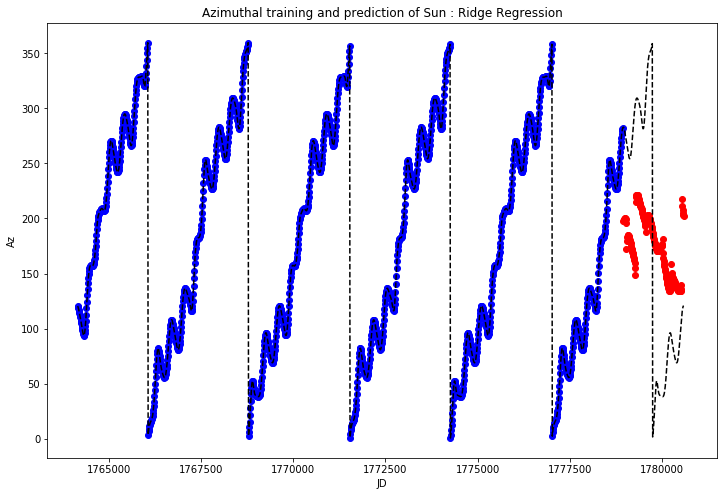

In [147]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Az', body='Sun', model='Ridge', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Sun']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Az'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Az')
plt.title('Azimuthal training and prediction of Sun : Ridge Regression')
plt.show()

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': None, 'estimator__normalize': False, 'estimator__random_state': None, 'estimator__solver': 'auto', 'estimator__tol': 0.001, 'estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


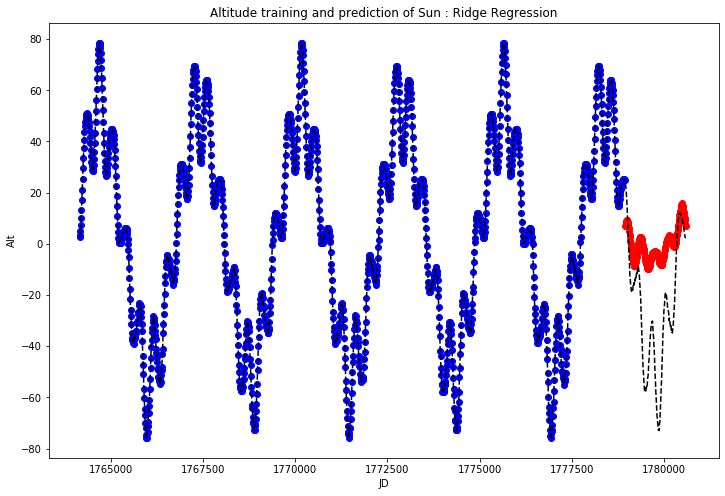

In [148]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', body='Sun', model='Ridge', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Sun']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Sun : Ridge Regression')
plt.show()

### 1-2 Results : LASSO of Sun position

In [ ]:
# mse of LASSO with different number of features
LASSO_mse_train = {}
LASSO_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    LASSO_mse_train[i] = []
    LASSO_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i,body='Sun', model='LASSO', num_feature = num_feature)
        LASSO_mse_train[i].append(mse_train)
        LASSO_mse_test[i].append(mse_test)

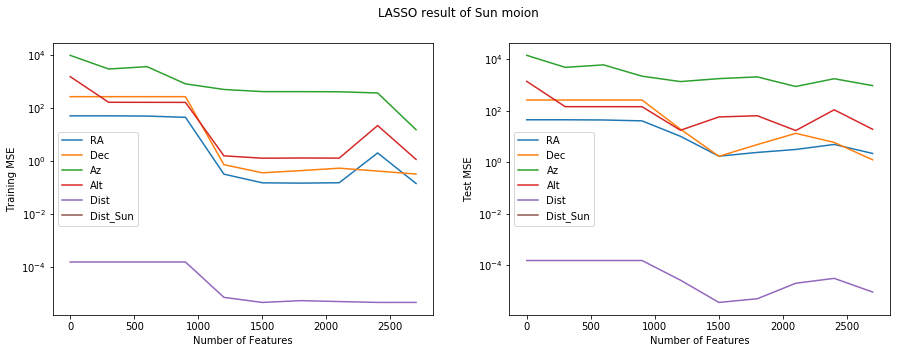

In [118]:
train_test_plot(traindata=LASSO_mse_train, testdata=LASSO_mse_test, numfeatures=num_features, 
                suptitle = 'LASSO result of Sun moion')

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


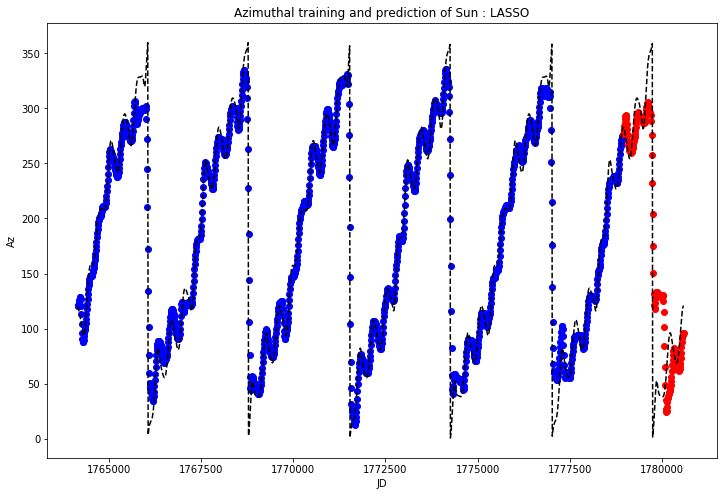

In [149]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Az', body='Sun', model='LASSO', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Sun']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Az'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Az')
plt.title('Azimuthal training and prediction of Sun : LASSO')
plt.show()

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


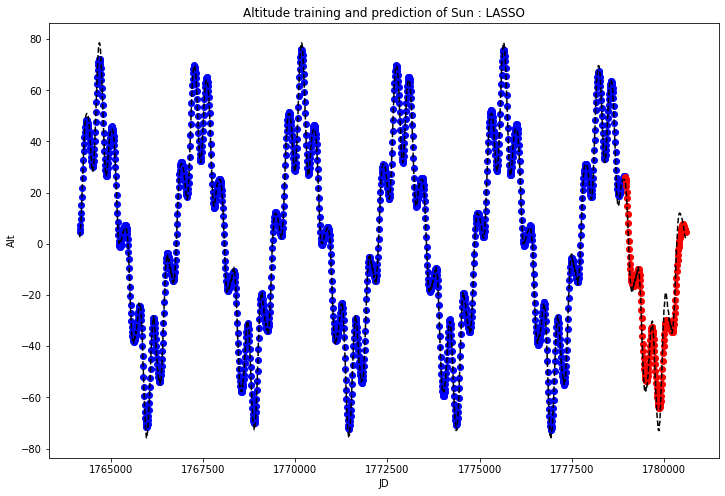

In [151]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', body='Sun', model='LASSO', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Sun']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Sun : LASSO')
plt.show()

### Addition Results : LASSO of Moon position

In [5]:
# mse of LASSO with different number of features
LASSO_mse_train = {}
LASSO_mse_test = {}
target = ['RA', 'Dec', 'Az', 'Alt', 'Dist', 'Dist_Sun']
num_features = np.arange(1, 3001, 300)
for i in target:
    LASSO_mse_train[i] = []
    LASSO_mse_test[i] = []
    for num_feature in num_features:
        mse_train, mse_test = regression_models_ff(target = i,body='Moon', model='LASSO', num_feature = num_feature)
        LASSO_mse_train[i].append(mse_train)
        LASSO_mse_test[i].append(mse_test)

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95.322379500014, tolerance: 47.655718542243285
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217.1324764761564, tolerance: 48.02580824699613
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter 

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48.74904853277371, tolerance: 47.83479383333243
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.1644679529943, tolerance: 47.655718542243285
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normal

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11907.924284857, tolerance: 9756.532131168258
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 811094.1189640003, tolerance: 99288.5163907804
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. Y

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489393.43910159986, tolerance: 99288.5163907804
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250695.25782513345, tolerance: 97565.32131168258
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converg

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196134.49634840485, tolerance: 99288.5163907804
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180683.76529152662, tolerance: 97571.09095670056
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converg

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}
{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normal

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1637.356979293499, tolerance: 1454.0964564290598
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1464.511095509181, tolerance: 1454.0964564290598
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1874.7188666255147, tolerance: 1450.0426356394198
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parame

{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1771.6732647698614, tolerance: 1454.0964564290598
  positive)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1781.427350295981, tolerance: 1450.0426356394198
  positive)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


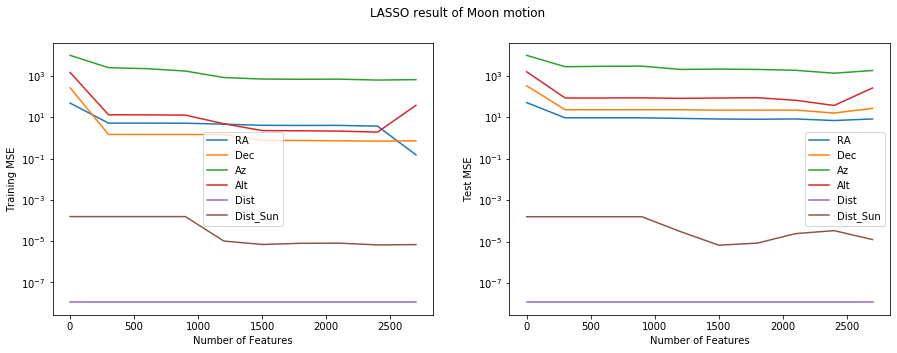

In [7]:
train_test_plot(traindata=LASSO_mse_train, testdata=LASSO_mse_test, numfeatures=num_features, 
                suptitle = 'LASSO result of Moon motion')

/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/yun/anaconda3/envs/pymatgen/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'cv': 'warn', 'error_score': 'raise-deprecating', 'estimator__alpha': 1.0, 'estimator__copy_X': True, 'estimator__fit_intercept': True, 'estimator__max_iter': 1000, 'estimator__normalize': False, 'estimator__positive': False, 'estimator__precompute': False, 'estimator__random_state': None, 'estimator__selection': 'cyclic', 'estimator__tol': 0.0001, 'estimator__warm_start': False, 'estimator': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'iid': 'warn', 'n_jobs': None, 'param_grid': {'alpha': [100, 10, 1, 0.1, 0.01, 0.001], 'tol': [1, 0.1, 0.01, 0.001]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


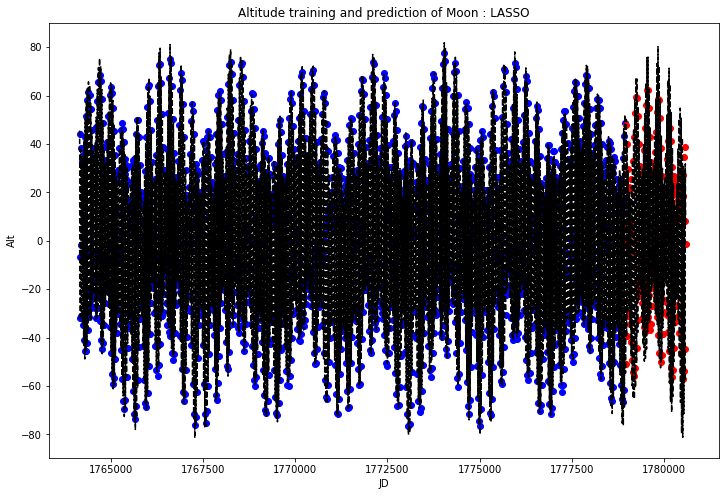

In [9]:
train_JD, test_JD, y_train, y_test = regression_models_ff(target = 'Alt', body='Moon', model='LASSO', num_feature = 1500, option=True)
dfSun = df.loc[df['Body'] == 'Moon']
plt.figure(figsize=(12, 8))
plt.scatter(train_JD, y_train, c='b', label='train')
plt.scatter(test_JD, y_test, c='r', label='test')
plt.plot(dfSun['JD'].values, dfSun['Alt'].values, 'k--', label='real')
plt.xlabel('JD')
plt.ylabel('Alt')
plt.title('Altitude training and prediction of Moon : LASSO')
plt.show()